# Vegetable Image Classification

## Exercise 1: Building a Convnet from Scratch

In this exercise, we will build a classifier model from scratch that is able to distinguish among 15 different types of vegetables. Similarly to our last lab, we will:

1. Explore the example data
2. Build a small convnet from scratch to solve our classification problem
3. Evaluate training and validation accuracy

Let's go!

## Explore the Example Data

Let's start by downloading our example data, a .zip of 21,000 JPG pictures of vegetables, and extracting it locally in `/tmp`. These data are replicated from the [Kaggle Vegetable Image Dataset](https://www.kaggle.com/datasets/misrakahmed/vegetable-image-dataset)

In [2]:
!if ! [ -f /tmp/vegetables.zip ]; then \
  wget --no-check-certificate \
    https://cdn.c18l.org/vegetables.zip \
    -O /tmp/vegetables.zip; \
fi

In [3]:
import os
import zipfile

local_zip = '/tmp/vegetables.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/tmp')
zip_ref.close()

The contents of the .zip are extracted to the base directory `/tmp/Vegetable Images`, which contains `train`, `test`, and `validation` subdirectories for the training and validation datasets (see the [Machine Learning Crash Course](https://developers.google.com/machine-learning/crash-course/validation/check-your-intuition) for a refresher on training, validation, and test sets), which in turn each contain subdirectories for each of the image classes we'll be trying to predict. Let's define each of these directories:

In [4]:
from pathlib import Path

base_dir = Path('/tmp/Vegetable Images')
train_dir = base_dir / 'train'
test_dir = base_dir / 'test'
validation_dir = base_dir / 'validation'

image_classes = [x.name for x in train_dir.iterdir() if x.is_dir()]
image_classes

['Cauliflower',
 'Radish',
 'Papaya',
 'Broccoli',
 'Bottle_Gourd',
 'Carrot',
 'Brinjal',
 'Cabbage',
 'Potato',
 'Pumpkin',
 'Bitter_Gourd',
 'Capsicum',
 'Bean',
 'Tomato',
 'Cucumber']

Now, let's see what the filenames look like for some of our vegetables in a `train` subdirectory (file naming conventions are the same in the `test` and `validation` directory):

In [5]:
train_radish_fnames = os.listdir(train_dir / image_classes[0])
print(train_radish_fnames[:10])

test_radish_fnames = os.listdir(test_dir / image_classes[0])
print(test_radish_fnames[:10])

validation_radish_fnames = os.listdir(validation_dir / image_classes[0])
print(validation_radish_fnames[:10])

['0647.jpg', '0121.jpg', '0465.jpg', '0896.jpg', '0476.jpg', '0749.jpg', '0392.jpg', '0098.jpg', '0894.jpg', '0802.jpg']
['1124.jpg', '1150.jpg', '1054.jpg', '1232.jpg', '1079.jpg', '1161.jpg', '1101.jpg', '1177.jpg', '1131.jpg', '1115.jpg']
['1374.jpg', '1346.jpg', '1289.jpg', '1445.jpg', '1356.jpg', '1291.jpg', '1325.jpg', '1448.jpg', '1349.jpg', '1459.jpg']


Let's find out the total number of images in the `train` and `validation` directories:

In [6]:
print('total training radish images:', len(os.listdir(train_dir / image_classes[0])))
print('total testing radish images:', len(os.listdir(test_dir / image_classes[0])))
print('total validation radish images:', len(os.listdir(validation_dir / image_classes[0])))

total training radish images: 1000
total testing radish images: 200
total validation radish images: 200


For each image class, we have 1,000 training images, 200 test images, and 200 validation images.

Now let's take a look at a few pictures to get a better sense of what the dataset looks like. First, configure the matplot parameters:

In [7]:
%matplotlib inline

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Parameters for our graph; we'll output images in a 4x4 configuration
nrows = 4
ncols = 4

# Index for iterating over images
pic_index = 0

Now, display a batch of 8 radish pictures. You can rerun the cell to see a fresh batch each time:

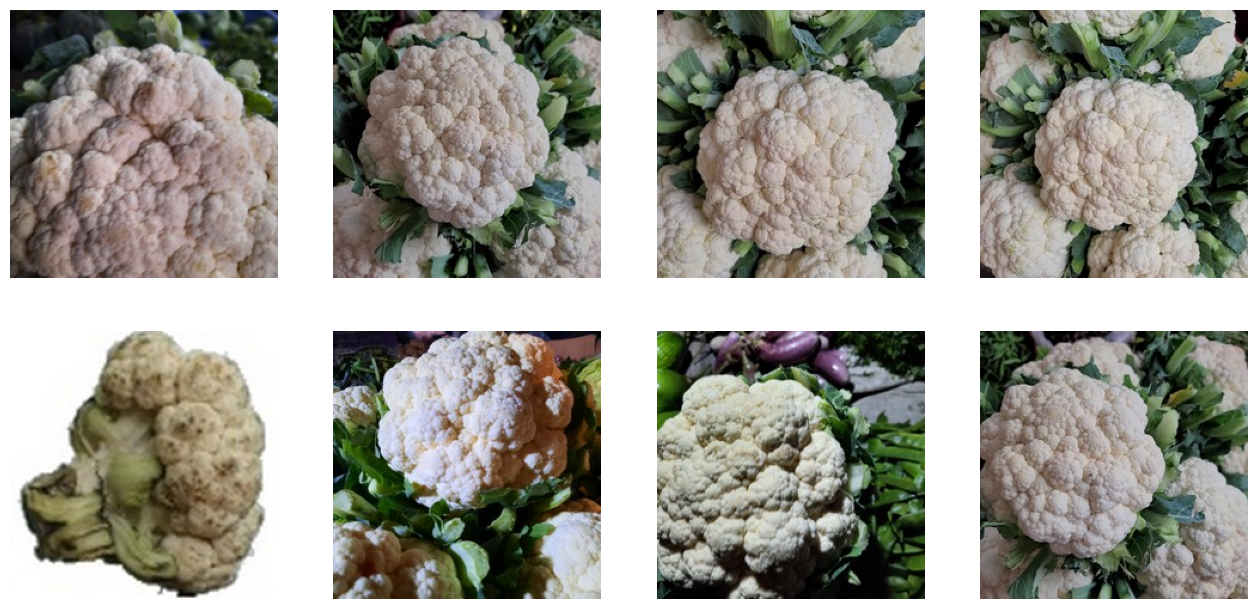

In [8]:
# Set up matplotlib fig, and size it to fit 4x4 pics
fig = plt.gcf()
fig.set_size_inches(ncols * 4, nrows * 4)

pic_index += 8
next_pix = [
    os.path.join(train_dir / image_classes[0], fname)
    for fname in train_radish_fnames[pic_index-8:pic_index]
]

for i, img_path in enumerate(next_pix):
    sp = plt.subplot(nrows, ncols, i + 1)
    sp.axis('Off')

    img = mpimg.imread(img_path)
    plt.imshow(img)

plt.show()

## Building a Small Convnet from Scratch

In [9]:
import tensorflow as tf


img_input = tf.keras.layers.Input(shape=(224, 224, 3))

conv1 = tf.keras.layers.Conv2D(24, 6, activation='relu')(img_input)
pooling1 = tf.keras.layers.MaxPooling2D(4)(conv1)
dropout = tf.keras.layers.Dropout(0.4)

flatten = tf.keras.layers.Flatten()(pooling1)

dense = tf.keras.layers.Dense(600, activation='relu')(flatten)
output = tf.keras.layers.Dense(15, activation='softmax')(dense)

In [10]:
model = tf.keras.Model(img_input, output)

In [11]:
model.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.RMSprop(),
    metrics=[tf.keras.metrics.CategoricalAccuracy()]
)

In [12]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 219, 219, 24)      2616      
                                                                 
 max_pooling2d (MaxPooling2  (None, 54, 54, 24)        0         
 D)                                                              
                                                                 
 flatten (Flatten)           (None, 69984)             0         
                                                                 
 dense (Dense)               (None, 600)               41991000  
                                                                 
 dense_1 (Dense)             (None, 15)                9015      
                                                             

In [13]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# All images will be rescaled by 1./255
train_datagen = ImageDataGenerator(rescale=1./255)
val_datagen = ImageDataGenerator(rescale=1./255)

# Flow training images in batches of 20 using train_datagen generator
train_generator = train_datagen.flow_from_directory(
    test_dir,
    target_size=(224, 224),
    batch_size=20,
    class_mode='categorical')

# Flow validation images in batches of 20 using val_datagen generator
validation_generator = val_datagen.flow_from_directory(
    validation_dir,
    target_size=(224, 224),
    batch_size=20,
    class_mode='categorical')

Found 3000 images belonging to 15 classes.
Found 3000 images belonging to 15 classes.


In [14]:
%load_ext tensorboard

In [15]:
import os
import datetime

logdir = os.path.join("logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1)

In [ ]:
%tensorboard --logdir logs

In [ ]:
history = model.fit(
    train_generator,
    steps_per_epoch=100,
    epochs=15,
    callbacks=[tensorboard_callback])

Epoch 1/15
100/100 [==============================] - ETA: 0s - loss: 3.4353 - categorical_accuracy: 0.3005